In [1]:
%matplotlib inline
from edgenerator import make_graph
from biom import load_table
from jinja2 import Environment
from json import dumps
from skbio import DistanceMatrix
from scipy.spatial.distance import euclidean

import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def load_mf(fn):
    _df = pd.read_csv(fn, sep='\t', dtype=str, keep_default_na=False, na_values=[])
    _df.set_index('#SampleID', inplace=True)
    return _df

In [3]:
mf = load_mf('emp_qiime_mapping_all_emp.tsv')
dm = DistanceMatrix.read('filtered.emp-90-gg-1k-unweighted_unifrac.txt')

mf = mf.loc[list(dm.ids)].copy()

mf['latitude_deg'] = pd.to_numeric(mf['latitude_deg'], errors='coerce')
mf['longitude_deg'] = pd.to_numeric(mf['longitude_deg'], errors='coerce')

In [4]:
min_edges = pd.read_csv('minimum-edge-list.txt', sep='\t', header=None).as_matrix().tolist()

In [5]:
f = nx.Graph()
for u, v, d in min_edges:
    f.add_edge(u, v, attr_dict={'weight': d})

In [6]:
# get only these two columns as a dict, retrieving
# only samples present in the graph
attribs = mf[['latitude_deg', 'longitude_deg', 'empo_3', 'title']].loc[f.nodes()].to_dict()

nx.set_node_attributes(f, 'latitude_deg', attribs['latitude_deg'])
nx.set_node_attributes(f, 'longitude_deg', attribs['longitude_deg'])
nx.set_node_attributes(f, 'empo_3', attribs['empo_3'])

In [7]:
!head minimum-edge-list.txt

1883.2009.15.Crump.Artic.LTREB.main.lane3.NoIndex	1883.2011.346.Crump.Artic.LTREB.main.lane4.NoIndex	0.632079
2080.S24D85	2080.S16D90	0.391546
1711.KAJ7.2	1721.S9M	0.661784
1037.IDF1.OM2C0.ORG	1037.IDF2.OM2C0.ORG	0.541306
1632.E5H06.Knight16sV4.JuannaBirdEMP.NoIndex.L005.R1.001.sequences	2382.DPOO1.C1.HA.5.650.gp.9.12.lane8.NoIndex.L008.sequences	0.393665
1716.McG.PAPrS33	1716.McG.PAPrS14	0.598470
1714.McG.LB210	1714.McG.LB02	0.510991
678.OA.mesocosm.405	678.OA.mesocosm.361	0.638682
632.Arctic.Tundra.2	632.Arctic.Tundra.1	0.604597
1453.45661SDZ2.G8.Pnem.stom	1453.45661SDZ2.F8.Pnem.stom	0.206431


In [8]:
data = []

for u, v, weight in f.edges_iter(data=True):
    unifrac = weight['weight']
   
    # euclidean geographical distance between samples
    try:
        geographical = euclidean([mf.loc[u]['latitude_deg'], mf.loc[u]['longitude_deg']],
                                 [mf.loc[v]['latitude_deg'], mf.loc[v]['longitude_deg']])
    except ValueError:
        geographical = np.nan
    
    emp_u = mf.loc[u]['empo_3']
    emp_v = mf.loc[v]['empo_3']
    
    data.append([unifrac, geographical, u, v, emp_u, emp_v])

df = pd.DataFrame(data=data,
                  columns=['unifrac', 'geographical',
                           'u', 'v', 'empo_3_u', 'empo_3_v'])


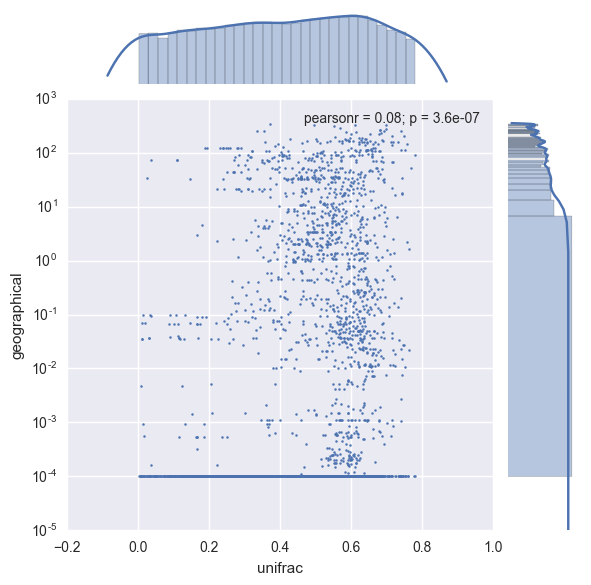

In [9]:
pseudo_df = df.copy()
pseudo_df['geographical'] = pseudo_df['geographical'] + 0.0001
g = sns.jointplot(x='unifrac', y='geographical', data=pseudo_df, s=2,
                  marginal_kws={'hist_kws': {'log': True}, 'kde':True})
plt.ylim([10**-5, 10**3])

g.fig.get_axes()[0].set_yscale('log')
g.ax_marg_x.set_axis_off()
g.ax_marg_y.set_axis_off()

Phylogenetic similarity is weakly correlated to geographical proximity. When we compare the *UniFrac distance* of only the closest pairs of samples to their *geographical distance*, we find a weak and statistically significant correlation between the samples (R = 0.08, p < 0.001). Showing that for the sampled environments physical proximity is **faintly** associated with similar microbial compositions, if this pattern was more dominant we would not observe the edges going across the globe in the [microbial map](https://eldeveloper.github.io/cogs220/). Of note, these edges are observed between samples of distinct environments, and samples of the same environment (according to the EMPO_3 category). 